# Implémentation

##Includes

In [ ]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import output
import skimage.morphology as morpho  
from skimage.segmentation import watershed
import scipy.io


##Useful functions

In [ ]:
def reshapeMask(mask):
  maskSize = mask.shape[0] + 1
  newmask = np.zeros((maskSize, maskSize))
  newmask[:-1,:-1] = newmask[:-1,:-1] + mask
  return np.matrix(newmask)

In [ ]:
def conv(m1, m2):
  size = m1.shape[0]
  res = 0
  for i in range(size):
    for j in range(size):
      res += m1[i,j] * m2[(size - 1) - i, (size - 1) - j]
  return res

In [ ]:
def padMatrix(matrix, borderOffset, padValue):
  height, width = matrix.shape

  topBorder = borderOffset
  bottomBorder = height+borderOffset
  leftBorder = borderOffset
  rightBorder = width+borderOffset

  paddedMatrix = np.ones((height+2*borderOffset, width+2*borderOffset))*padValue
  paddedMatrix[topBorder:bottomBorder, leftBorder:rightBorder] = matrix
  return paddedMatrix

def unpadMatrix(matrix, borderOffset):
  height, width = matrix.shape
  topBorder = borderOffset
  bottomBorder = height-borderOffset
  leftBorder = borderOffset
  rightBorder = width-borderOffset

  return matrix[topBorder:bottomBorder, leftBorder:rightBorder]


In [ ]:
def applyFilterXY(img, mask):
  filterX = linearFilter(img, mask)
  filterY = linearFilter(img, np.rot90(mask))
  return np.sqrt(filterX**2 + filterY**2)

In [ ]:
def seuil (image, seuilValue):
  return 255.0*(image > seuilValue)


In [ ]:
def efficientSeuil(img, gridStep, mask):
  distanceSeeds = 10**6*np.ones((1, gridStep+1))
  distanceSeeds[0][0] = 0
  distanceSeeds[0][-1] = 0
  maskDistance = createDistanceMap(distanceSeeds, mask)

  seuilValue = maskDistance[0][maskDistance.shape[1]//2 - 2]

  return seuil(img, seuilValue)

In [ ]:
def getMask(maskType):
  return {
      'manhattan': np.matrix([[2,1,2],[1,0,1],[2,1,2]]),
      'chessBoard': np.matrix([[1,1,1],[1,0,1],[1,1,1]]),
      'chamfer-3-4': np.matrix([[4,3,4],[3,0,3],[4,3,4]]),
      'chamfer-5-7-11': np.matrix([[np.Inf,11,np.Inf,11,np.Inf],[11,7,5,7,11],[np.Inf,5,0,5,np.Inf],[11,7,5,7,11],[np.Inf,11,np.Inf,11,np.Inf]]),
      'sobel': np.matrix([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]),
      'difference': np.matrix([[1,0], [0,-1]])
  }.get(maskType, np.matrix([[1,1,1],[1,0,1],[1,1,1]]))

In [ ]:
def crop(img, xmin, xmax, ymin, ymax):
  return img[ymin:ymax+1, xmin:xmax+1]

In [ ]:
def normalize(img):
  return 255.0*img/np.max(img)

In [ ]:
def Union(struct, A, B):
  rootA = Find(struct, A)
  rootB = Find(struct, B)
  if(rootA != rootB):
    struct[B] = A
  return struct

def Find(struct, A):
  if struct[A] == A:
    return A
  return Find(struct, struct[A])

In [ ]:
def labelMapToDict(img, labels):
  height, width = img.shape
  labelsDict = {}
  uniqueLabels = np.unique(labels)
  for label in uniqueLabels:
    labelsDict.update({label : [[],[],[]]})

  for i in range(height):
    for j in range(width):
      labelsDict[labels[i][j]][0].append(j)
      labelsDict[labels[i][j]][1].append(i)
      labelsDict[labels[i][j]][2].append(img[i][j])

  return labelsDict

def labelDictToMap(labelsDict):
  xMax, yMax = 0, 0
  for label in labelsDict:
    labelXMax = max(labelsDict[label][0])
    labelYMax = max(labelsDict[label][1])
    if labelXMax > xMax:
      xMax = labelXMax
    if labelYMax > yMax:
      yMax = labelYMax
                 
  labelsMap = np.zeros((yMax+1, xMax+1))

  for label in labelsDict:
    for i in range(len(labelsDict[label][0])):
      labelsMap[labelsDict[label][1][i], labelsDict[label][0][i]] = label

  return labelsMap

In [ ]:
def setColors(targetImage, targetPixels, R, G, B):
  targetImage = np.copy(targetImage)
  if(len(targetImage.shape) < 3):
    targetImage = cv2.merge([targetImage, targetImage, targetImage])
  for i in range(targetImage.shape[0]):
    for j in range(targetImage.shape[1]):
      if(targetPixels[i][j]):
        targetImage[i][j][0] = B*targetPixels[i][j]
        targetImage[i][j][1] = G*targetPixels[i][j]
        targetImage[i][j][2] = R*targetPixels[i][j]
  
  return targetImage

In [ ]:
def visualizeResult(imgPath, watershed):

  colorImg = readImage(imgPath, 1)
  cv2_imshow(colorImg)

  edges = 1.0*(watershed == 0)

  R, G, B = 255, 0, 0
  colorImg = setColors(colorImg, edges, R, G, B)          
  cv2_imshow(colorImg)

In [ ]:
def readGroundTruth(imgPath):
  #imgPath format example: "/test/36046.mat"
  mat = scipy.io.loadmat('BSR/BSDS500/data/groundTruth' + imgPath)
  return normalize(mat['groundTruth'][0][0][0][0][1])

In [ ]:
def readImage(imgPath, color = 0):
  #imgPath format example: "/train/100075.jpg"
  return cv2.imread('./BSR/BSDS500/data/images' + imgPath, color)

##Import pictures

In [ ]:
!wget "https://pmdvod.nationalgeographic.com/NG_Video/356/98/musi%20bonus1-1920x1080.jpg";
!mv "musi bonus1-1920x1080.jpg" "cat";
!wget "https://www.huber.embl.de/EBImage/ExampleImages/lena-original.tif";
!mv "lena-original.tif" "lena";

#Download and extract Berkeley Segmentation Dataset's files. Uncomment if it's not downloaded yet.
!wget http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz -O BSR.tgz;
!tar -xzf ./BSR.tgz;

--2021-11-24 19:05:05--  https://pmdvod.nationalgeographic.com/NG_Video/356/98/musi%20bonus1-1920x1080.jpg
Resolving pmdvod.nationalgeographic.com (pmdvod.nationalgeographic.com)... 23.44.110.109
Connecting to pmdvod.nationalgeographic.com (pmdvod.nationalgeographic.com)|23.44.110.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1548979 (1.5M) [image/jpeg]
Saving to: ‘musi bonus1-1920x1080.jpg’

musi bonus1-1920x10 100%[===================>]   1.48M  --.-KB/s    in 0.07s   

2021-11-24 19:05:05 (20.6 MB/s) - ‘musi bonus1-1920x1080.jpg’ saved [1548979/1548979]

--2021-11-24 19:05:05--  https://www.huber.embl.de/EBImage/ExampleImages/lena-original.tif
Resolving www.huber.embl.de (www.huber.embl.de)... 194.94.44.60
Connecting to www.huber.embl.de (www.huber.embl.de)|194.94.44.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 786572 (768K) [image/tiff]
Saving to: ‘lena-original.tif’

lena-original.tif   100%[===================>] 768.

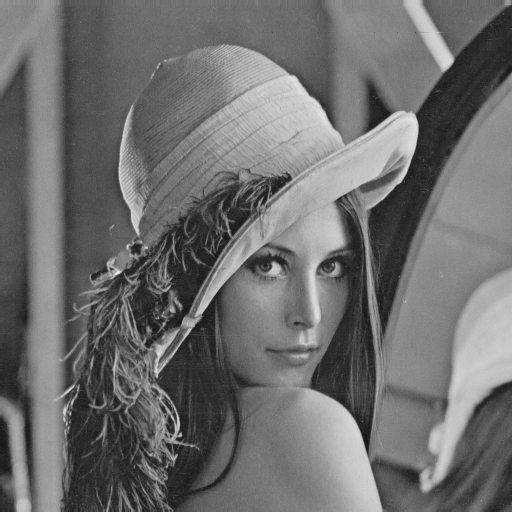

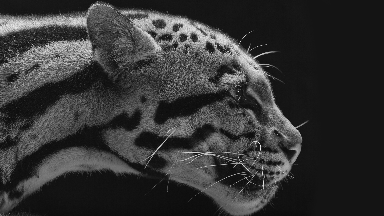

In [ ]:
img = cv2.imread("cat", 0)
lena = cv2.imread("lena", 0)
img = cv2.resize(img, (384,216))
cv2_imshow(lena)
cv2_imshow(img)

## Gradient


In [ ]:
def linearFilter(img, mask):
  img = np.matrix(img)
  mask = np.matrix(mask)
  maskSize = mask.shape[0]

  img = padMatrix(img, maskSize//2, 0)

  rows, cols = img.shape
  newImg = np.zeros((rows, cols))

  if not (maskSize % 2):
    mask = reshapeMask(mask)
    maskSize += 1

  marginLeft = maskSize//2
  marginRight = cols - 1 - maskSize//2
  marginTop = maskSize//2
  marginBottom = rows - 1 - maskSize//2

  for i in range(marginTop, marginBottom + 1):
    for j in range(marginLeft, marginRight + 1):
        selectedPixels = img[i-maskSize//2:i+maskSize//2+1, j-maskSize//2:j+maskSize//2+1]
        newImg[i,j] = conv(selectedPixels, mask)

  return unpadMatrix(newImg, maskSize//2)


Gradient avec un filtre différence

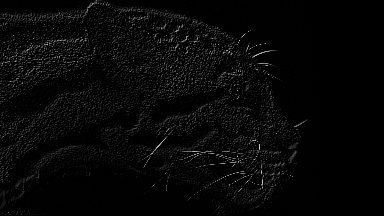

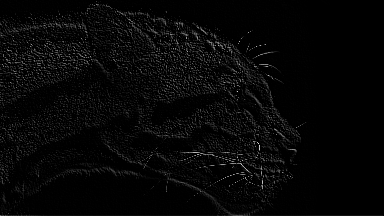

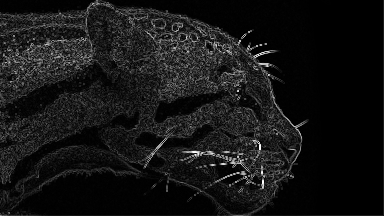

In [ ]:
imgX = linearFilter(img, getMask('difference'))
imgY = linearFilter(img, np.rot90(getMask('difference')))
cv2_imshow(imgX)
cv2_imshow(imgY)
nimf = applyFilterXY(img, getMask('difference'))
cv2_imshow(nimf)


Gradient avec un filtre de Sobel

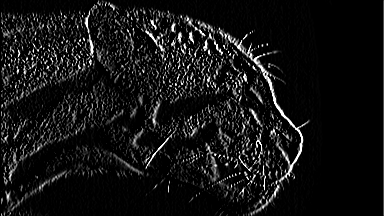

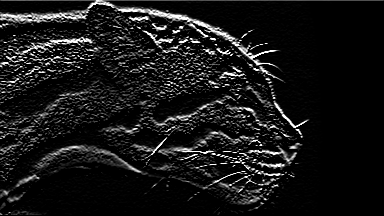

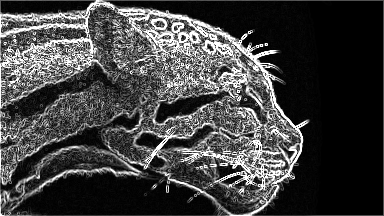

In [ ]:
imgX = linearFilter(img, getMask('sobel'))
imgY = linearFilter(img, np.rot90(getMask('sobel')))
cv2_imshow(imgX)
cv2_imshow(imgY)
nimf = applyFilterXY(img, getMask('sobel'))
cv2_imshow(nimf)

## Seeds generation

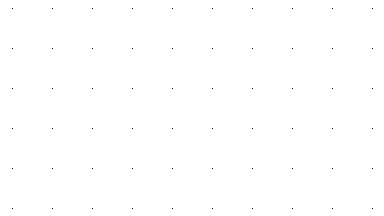

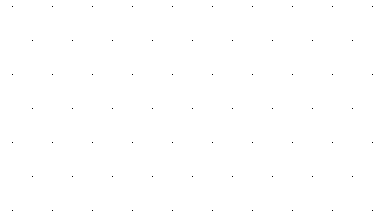

In [ ]:
def generateSeeds(img, gridStep, shape):
  height, width = img.shape
  seedsMap = np.ones((height, width))*10**6
  
  spSide = int(gridStep)
  spHeight = int(spSide*np.sqrt(3)/2) if shape else spSide

  horizontalOffset = int(np.floor((width%spSide)/2))
  verticalOffset = int(np.floor((height%spHeight)/2))

  shapeOffset = 0
  if shape:
    shapeOffset = int(np.ceil(spSide/2))
  
  seedsIndexes = []
  line = 0
  for i in range(verticalOffset, height, spHeight):
    for j in range(horizontalOffset, width,spSide):
      shapeJ = j + (line%2)*shapeOffset
      if (shapeJ < width):
        seedsMap[i][shapeJ] = 0
        seedsIndexes.append((i,shapeJ))
    line +=1;
    
  seedsIndexes = np.array(seedsIndexes)
  return seedsMap, spSide, seedsIndexes

map, gridStep, seedsPositions = generateSeeds(img, 40, 0)
cv2_imshow(map)
print('')
map, gridStep, seedsPositions = generateSeeds(img, 40, 1)
cv2_imshow(map)

## Distance Map


In [ ]:
def createDistanceMap(seeds, mask):
  maskSize = mask.shape[0]
  padSize = maskSize//2
  distanceMap = padMatrix(seeds, padSize, np.Inf)
  origHeight, origWidth = seeds.shape
  height, width = distanceMap.shape

  forwardsMask = mask[0:maskSize//2+1, 0:maskSize]
  forwardsMask = np.zeros(forwardsMask.shape) + forwardsMask
  forwardsMask[-1, maskSize//2:mask.shape[1]] = np.Inf

  backwardsMask = mask[maskSize//2:maskSize, 0:maskSize]
  backwardsMask = np.zeros(backwardsMask.shape) + backwardsMask
  backwardsMask[0, 0:maskSize//2+1] = np.Inf
  
  for i in range(padSize, padSize+origHeight):
    for j in range(padSize, padSize+origWidth):
      compMatrix = distanceMap[i-padSize:i+1, j-padSize:j+padSize+1] + forwardsMask
      minValue = min(distanceMap[i,j], np.min(compMatrix))
      distanceMap[i,j] = minValue

  for i in range(padSize+origHeight-1, padSize-1, -1):
    for j in range(padSize+origWidth-1, padSize-1, -1):
      compMatrix = distanceMap[i:i+padSize+1, j-padSize:j+padSize+1] + backwardsMask
      minValue = min(distanceMap[i,j], np.min(compMatrix))
      distanceMap[i,j] = minValue

  return unpadMatrix(distanceMap, padSize)

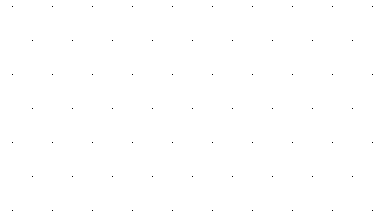

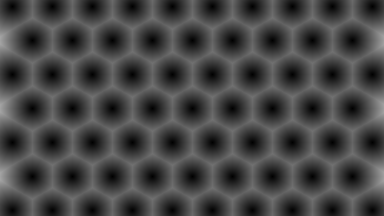

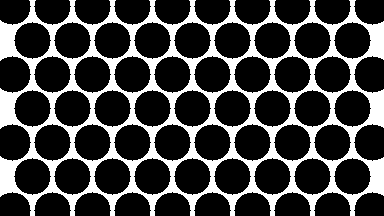

In [ ]:
map, gridStep, seedsPositions = generateSeeds(img, 40, 1)
cv2_imshow(map)
d = createDistanceMap(map, getMask('chamfer-5-7-11'))
cv2_imshow(d)

dt = efficientSeuil(d, gridStep, getMask('chamfer-5-7-11'))
cv2_imshow(dt)

## Composantes connexes

In [ ]:
def getAllNeighbors(i,j,image):
  height, width = image.shape
  neighbors = []
  if i != 0:
    neighbors.append([i-1, j, image[i-1][j]])
  if j != 0:
    neighbors.append([i, j-1, image[i][j-1]])
  return np.array(neighbors)

def getNeighborsLabels(neighbors, labels):
  neighborsLabels = []
  for i in range(neighbors.shape[0]):
    neighborsLabels.append(labels[int(neighbors[i][0])][int(neighbors[i][1])])
  return neighborsLabels

In [ ]:
def connectComponents(image):
  height, width = image.shape

  backgroundColor = np.max(image)
  backgroundThreshold = 10**6
  linked = [set([])]*(height*width)
  labels = backgroundThreshold*np.ones((height, width))
  currentLabel = 0

  #First pass
  for i in range(height):
    for j in range(width):
      if image[i][j] != backgroundColor:
        allNeighbors = getAllNeighbors(i,j,image)
        connectedNeighbors = allNeighbors[allNeighbors[:,2] == image[i,j]] if allNeighbors.size else np.array([])

        if connectedNeighbors.size == 0:
          linked[currentLabel] = currentLabel
          labels[i][j] = currentLabel
          currentLabel += 1
        else:
          neighborsLabels = getNeighborsLabels(connectedNeighbors, labels)
          labels[i][j] = np.min(neighborsLabels)
          linked = Union(linked, int(np.min(neighborsLabels)), int(np.max(neighborsLabels)))

  #Second pass
  for i in range(height):
    for j in range(width):
      if image[i][j] != backgroundColor:
        labels[i][j] = Find(linked, int(labels[i][j]))

  #Third pass
  i = 0
  uniqueLabels = np.unique(labels)
  while i < uniqueLabels.size:
    if uniqueLabels[i] != backgroundThreshold:
      labels[labels == uniqueLabels[i]] = i
      i += 1
    else:
      uniqueLabels = np.delete(uniqueLabels, i)
  labels[labels == backgroundThreshold] = i

  return labels.astype(int)

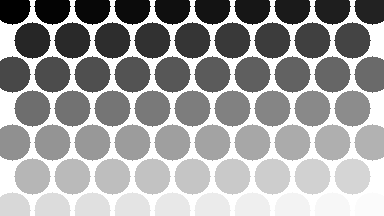

#tags:  68


In [ ]:
labels = connectComponents(dt)
cv2_imshow(normalize(labels))
print("#tags: ", np.unique(labels).size)

##Obtention des marqueurs

In [ ]:
def getLabelLimits(label, labelsDict):
  xMin = min(labelsDict[label][0])
  xMax = max(labelsDict[label][0])
  yMin = min(labelsDict[label][1])
  yMax = max(labelsDict[label][1])
  return xMin, xMax, yMin, yMax

def getLocalMinima(label, grad, labelsDict, labelsMap):
  xMin, xMax, yMin, yMax = getLabelLimits(label, labelsDict)

  localGrad = crop(grad, xMin, xMax, yMin, yMax)
  localLabels = crop(labelsMap, xMin, xMax, yMin, yMax)

  minGrad = np.min(localGrad[localLabels == label])

  minimaPixels = 255*np.ones((yMax-yMin+1, xMax-xMin+1))
  for i in range(yMax-yMin+1):
    for j in range(xMax-xMin+1):
      if localGrad[i][j] == minGrad and localLabels[i][j] == label:
        minimaPixels[i][j] = 0
  
  return minimaPixels

def selectLargestConnectedComponent(labels):
  maxCount = 0
  maxLabel = 0
  for currentLabel in np.unique(labels)[0:-1]:
    labelCount = np.sum(labels == currentLabel)
    if(labelCount > maxCount):
      maxCount = labelCount
      maxLabel = currentLabel

  return 255.0*(labels == maxLabel)

def defineMarkers(grad, labelsMap, labelsDict):
  height, width = grad.shape
  markers = 255*np.ones((height, width))

  for label in np.sort(np.unique(labelsMap)[0:-1]):
    xMin, xMax, yMin, yMax = getLabelLimits(label, labelsDict)
    cellMinima = getLocalMinima(label, grad, labelsDict, labelsMap)
    localLabels = connectComponents(cellMinima)
    cellMarker = selectLargestConnectedComponent(localLabels)
    markers[yMin:yMax+1, xMin:xMax+1] -= cellMarker
  
  return markers

def convertMarkersFormat(markers):
  labeledMarkers = connectComponents(markers) + 1
  backgroundComponent = np.unique(labeledMarkers)[-1]
  labeledMarkers[labeledMarkers == backgroundComponent] = 0
  return labeledMarkers

##Création des waterpixels

In [ ]:
def generateWaterPixels(imgPath, gridStep, spaceRegularization, distanceMapMask, visualize):
  img = readImage(imgPath)
  imgGrad = normalize(applyFilterXY(img, getMask('sobel')))

  distanceMapMask = getMask(distanceMapMask)
  grid, gridStep, seedsPositions = generateSeeds(img, gridStep, 1)

  gridDistanceMap = createDistanceMap(grid, distanceMapMask)
  gridDistanceMapSeuilee = efficientSeuil(gridDistanceMap, gridStep, distanceMapMask)

  labelsImg = connectComponents(gridDistanceMapSeuilee)
  labelsImgDict = labelMapToDict(img, labelsImg)
  markers = defineMarkers(imgGrad, labelsImg, labelsImgDict)
  seededDistanceMap = 2/gridStep*createDistanceMap(markers, distanceMapMask)

  labeledMarkers = convertMarkersFormat(markers)
  watershedTransform = watershed(imgGrad+spaceRegularization*seededDistanceMap, labeledMarkers, watershed_line=True)
  if (visualize):
    visualizeResult(imgPath, watershedTransform)
  return (watershedTransform, len(labelsImgDict.keys()) - 1)

#IMA201 - PROJET WATERPIXELS
###Lucas Oliveira - Lola Magnard

Dans le cadre de ce projet, notre objectif est de développer une bibliothèque en nous inspirant d'un article sur les waterpixels. Nos fonctions ont pour but de reproduire les résultats obtenus dans l’article tout en fournissant un ensemble de fonctions génériques permettant d’essayer différentes combinaisons de paramètres.

Les waterpixels sont un type de super pixels dont la création est basée sur l'idée de watershed transformation.

Obtenir les waterpixels d'une image se divise en plusieurs parties.


##A propos de l'implémentation


1 - Révéler les bords de l'image en réalisant un gradient. 

Pour cela il est nécessaire que l'image se trouve dans des teintes de gris.

Afin de réaliser cette étape, nous avons implémenté une fonction de convolution générique qui nous permet d'appliquer un masque de notre choix. Le masque de Sobel étant celui ayant montré les meilleurs résultats.


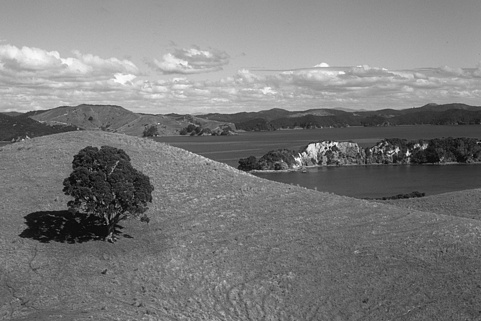

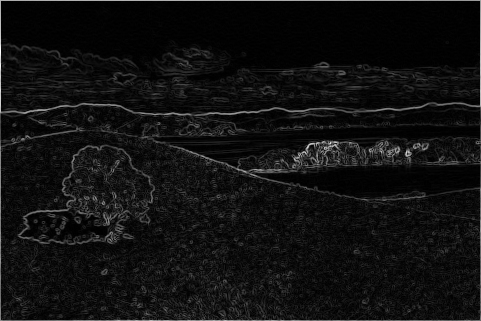

In [ ]:
imgPath = "/test/36046.jpg"
img = readImage(imgPath)
imgGrad = normalize(applyFilterXY(img, getMask('sobel')))
cv2_imshow(img)
cv2_imshow(imgGrad)

###2 - Obtenir une carte de distance à partir de seeds. 

Dans le paper il est mentionné qu'il est possible d'obtenir ces seeds en tenant compte de l'aspect de l'image, néanmoins cette technique n’y est pas implémentée. Nous avons donc opté pour reproduire la solution décrite dans le document en utilisant une grille géométrique. 

Notre fonction nous permet de générer une grille carrée ou hexagonale à partir de laquelle nous pourrons ensuite générer une carte de distance.Elle reçoit une image ainsi qu'un nombre qui nous permet de déterminer approximativement le nombre de seeds générées.


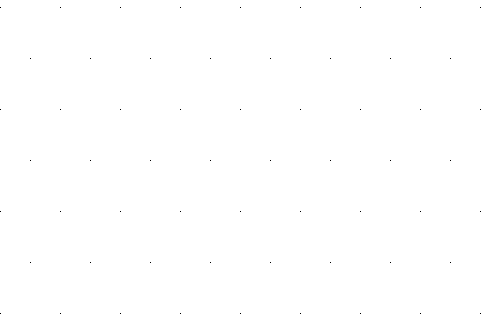

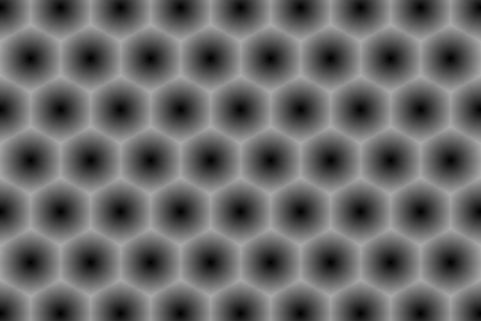

In [ ]:
grid, gridStep, seedsPositions = generateSeeds(img, 60, 1)
gridDistanceMap = createDistanceMap(grid, getMask('chamfer-5-7-11'))
cv2_imshow(grid)
cv2_imshow(gridDistanceMap)

###3 - Seuiller la carte de distance afin d'obtenir des cellules bien définies dans lesquelles nous chercherons les marqueurs. 

Il doit exister entre chaque cellule une zone dans laquelle on ne peut pas avoir de marqueur. Pour cette raison, nous avons implémenté la fonction seuil de telle sorte à ce que cette distance soit respectée quelque soit le nombre de seeds générés et quelque soit la taille de l'image. Ce calcul est réalisé en se basant sur la distance entre deux seeds. 

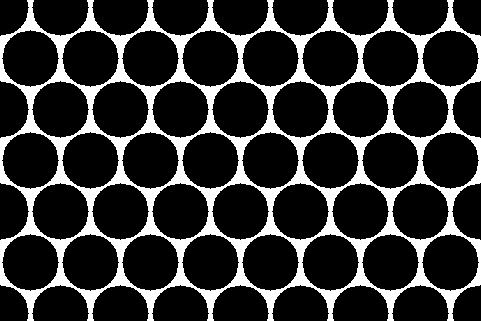

In [ ]:
gridDistanceMapSeuilee = efficientSeuil(gridDistanceMap, gridStep, getMask('chamfer-5-7-11'))
cv2_imshow(gridDistanceMapSeuilee)

###4 - Etiqueter chaque composente connexe et trouver le minimum du gradient dans chacune d'entre elle

Afin de pouvoir trouver le minimum local à l'interieur de chaque cellule, il nous a fallut étiqueter chaques composantes connexe. Pour cela nous avons implémenter un algoritme en trois passe.
Le premier passage est réalisé de gauche à droite et de haut en bas, il permet de réaliser une première identifications des voisins de chaques pixels. Le second passage est réalisé de dorite à gauche et de bas en haut et permet de fusioner les étiquettes correspondants à une même composente connexe. Suite à ce second passage, il est possible est les étiquettes se retrouvent désordonée, pour une question de clartée visuelle ous avons donc ajouté un troisième et dernier passage qui permet de d'organiser les étiquettes en ordre croissant.   

Une fois les composantes connexe obtenues, nous avons pu passer à la recherche des minimaux du gradient au sein de chaques cellules.

Afin d'obtenir les marqueurs, nous avons implémenté un algoritme qui: 
- reçoit une image
- trouve les valeurs minimums de cette image
- étiquette les différentes composantes connexes formée par ces minimums
- retourne la plus grosse composante connexe obtenu

Nous avons ensuite pris les limites de chaques composante connexe de notre image (xmin, xmax, ymin, ymax) afin de fair tourner notre algorithme sur ces sous-images et obtenir nos marqueurs. 

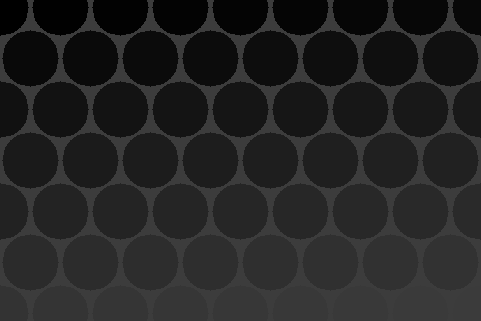

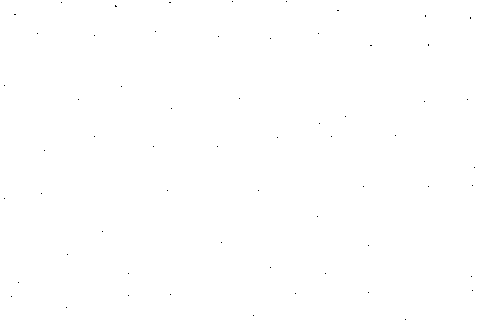

In [ ]:
labelsImg = connectComponents(gridDistanceMapSeuilee)
labelsImgDict = labelMapToDict(img, labelsImg)
markers = defineMarkers(imgGrad, labelsImg, labelsImgDict)

cv2_imshow(labelsImg)
cv2_imshow(markers)

###5 - Créer une carte de distance à partir des marqueurs

Une fois les marqueur obtenus, nous pouvions obtenir la carte des distances en utilisant simplement la fonction de carte de distance précédemment implémentée.  

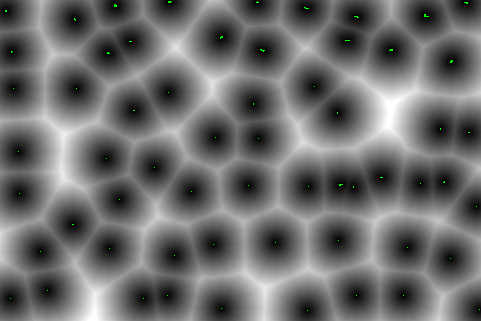

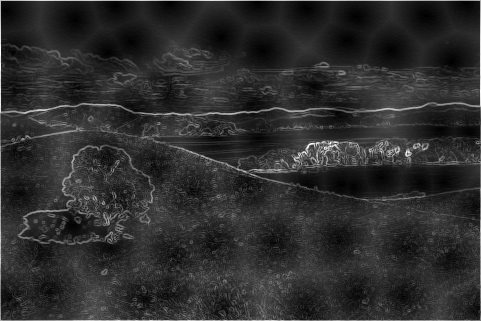

In [ ]:
k = 8
seededDistanceMap = 2/gridStep*createDistanceMap(markers, getMask('chamfer-5-7-11'))
cv2_imshow(setColors(normalize(seededDistanceMap), 255-markers, 0, 255, 0))
cv2_imshow(imgGrad + k*seededDistanceMap)

###6 - Appliquer la transformation "watershed"

Une fois la carte de distance des marqueurs et le gradient de l'image en main, on obtient le gradient spacialement régularisé en additionant le gradiant avec la carte de distance fois une constante k.

`redGrad = imgGrad + spaceRegularization * seededDistanceMap`

On peut ensuite appliquer directement l'algorithme de watershed sur notre gradient régularisé. 

Nous n'avons pas implémenté l'algoritme de watershed et avons utiliser celui de la bibliothèque skimage.

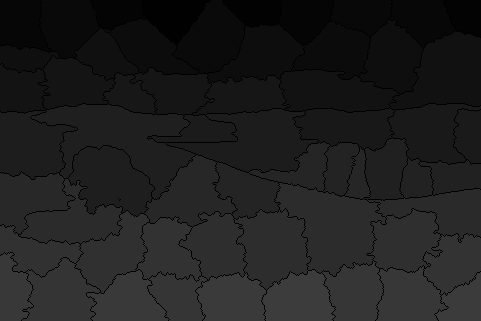

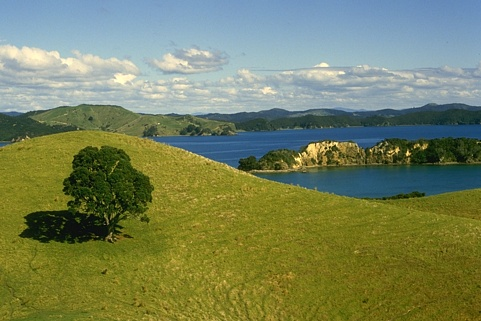

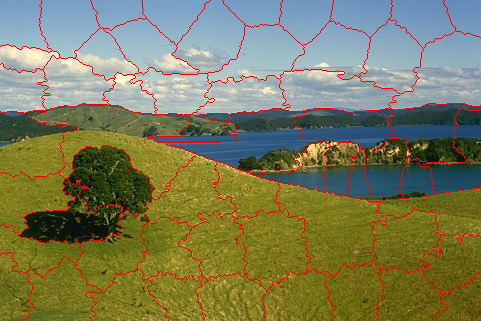

In [ ]:
labeledMarkers = convertMarkersFormat(markers)
watershedTransform = watershed(imgGrad+k*seededDistanceMap, labeledMarkers, watershed_line=True)
cv2_imshow(watershedTransform)

visualizeResult(imgPath, watershedTransform)


#Analyse

Afin de faciliter le processus d'analyse, les étape précédantes ont étés compilées dans la fonction *main*. 

##Fonctions utiles pour l'analyse

In [ ]:
def boundaryRecall(edges, groundTruth):
  wideEdges = morpho.dilation(edges, morpho.disk(2))
  hitEdges = np.logical_and(wideEdges, groundTruth)

  return np.sum(hitEdges)/np.count_nonzero(groundTruth)

In [ ]:
def contourDensity(edges):
  height, width = edges.shape

  edges = edges/255
  contourPixels = np.sum(edges)
  borderPixels = 2*height + 2*width - 4
  totalPixels = height*width

  return (contourPixels + borderPixels)/totalPixels

In [ ]:
def hitEdgesVisualization(watershedEdges, groundTruthPath, visualize = False):
  groundTruth = readGroundTruth(groundTruthPath)
  edges = 255*(watershedEdges == 0)
  wideEdges = morpho.dilation(edges, morpho.disk(2))
  hitEdges = normalize(np.logical_and(wideEdges, groundTruth))

  missedEdges = setColors(groundTruth, groundTruth, 255, 0, 0)
  result = setColors(missedEdges, hitEdges, 0, 255, 0)
  if visualize:
    cv2_imshow(result)
    print("Contour Density = ", contourDensity(edges))
    print("Boundary recall = ", boundaryRecall(edges, groundTruth))
  return result

In [ ]:
def testWaterPixelsValues(numberOfValues, imgPath, groundTruthPath, k):
  boundaryRecalls = []
  contourDensities = []
  superPixels = []
  numberOfValues += 1
  for i in range(1,numberOfValues):
    watershedEdges, superPixel = generateWaterPixels(imgPath, gridStep=9*i, spaceRegularization=k, distanceMapMask='chamfer-5-7-11', visualize=False)
    groundTruth = readGroundTruth(groundTruthPath)
    edges = 255*(watershedEdges == 0)

    boundaryRecalls.append(boundaryRecall(edges, groundTruth))
    contourDensities.append(contourDensity(edges))
    superPixels.append(superPixel)

  return (boundaryRecalls, contourDensities, superPixels)

##1 - Analyse qualitative

In [ ]:
imgPath = "/test/36046.jpg"
img = readImage(imgPath)

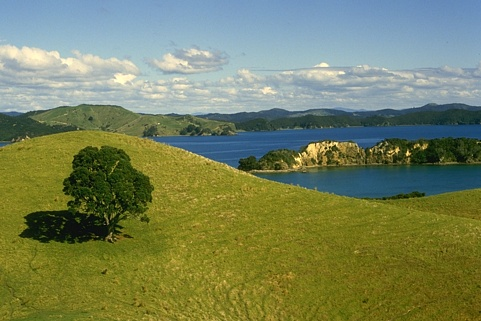

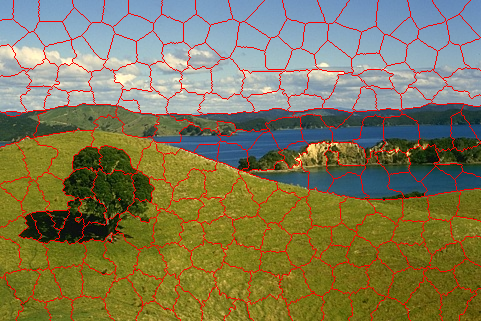

In [ ]:
watershedEdges, superPixels = generateWaterPixels(imgPath, gridStep=30, spaceRegularization=16, distanceMapMask='chamfer-5-7-11', visualize=True)

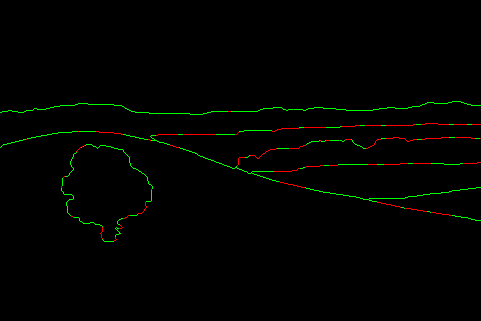

Contour Density =  0.07749949806024573
Boundary recall =  0.6781661370857921


In [ ]:
hitEdges = hitEdgesVisualization(watershedEdges, "/test/36046.mat", visualize = True)

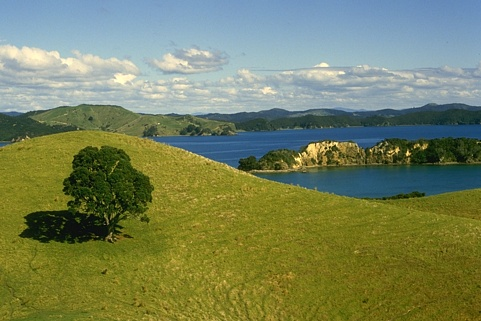

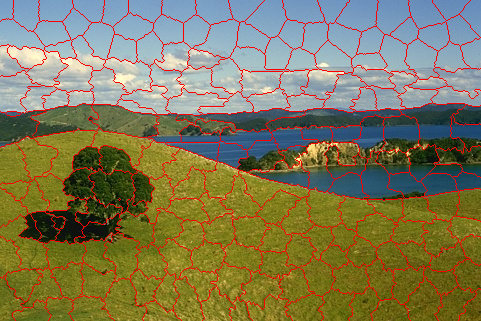

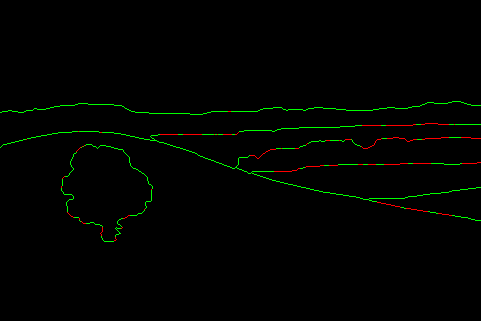

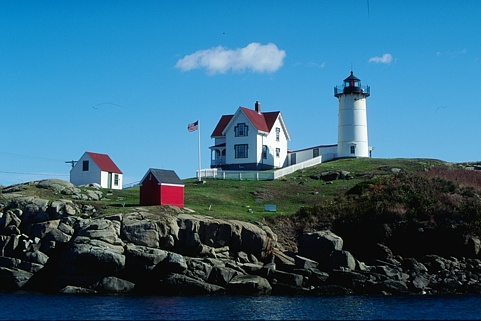

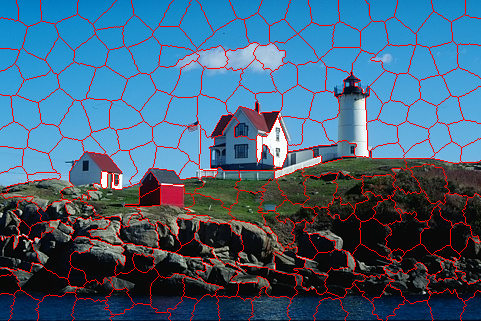

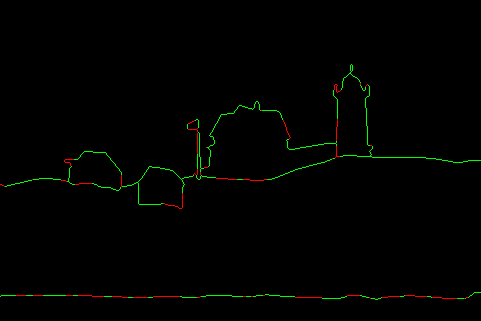

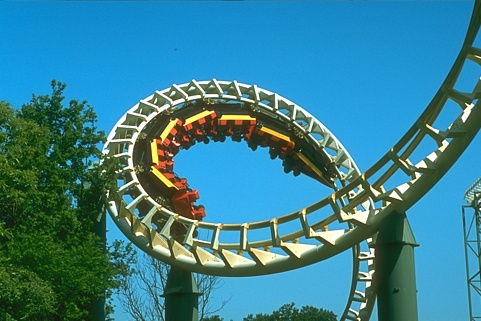

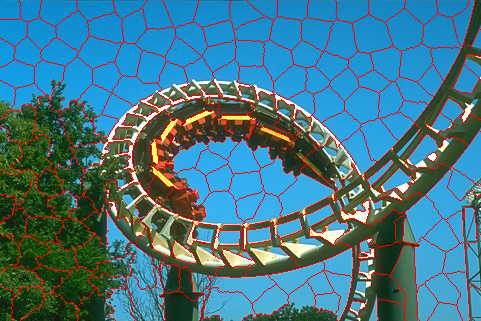

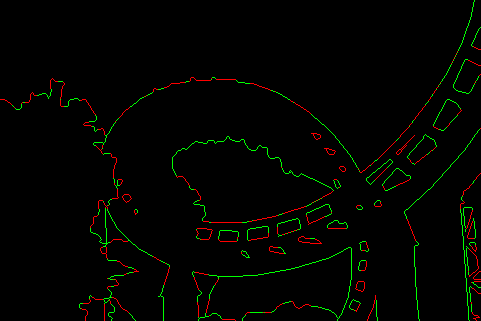

In [ ]:
imagePaths = ['/test/36046.jpg', '/test/228076.jpg', '/test/235098.jpg']
groundTruthPaths = ['/test/36046.mat', '/test/228076.mat', '/test/235098.mat']

for i in range(len(imagePaths)):
  imgPath = imagePaths[i]
  colorImg = readImage(imgPath, 1)
  watershedEdges, superPixels = generateWaterPixels(imgPath, gridStep=30, spaceRegularization=8, distanceMapMask='chamfer-5-7-11', visualize=False)
  colorImgWithEdges = setColors(colorImg, 1*(watershedEdges == 0), 255, 0, 0)
  hitEdges = hitEdgesVisualization(watershedEdges, groundTruthPaths[i])

  cv2_imshow(colorImg)
  cv2_imshow(colorImgWithEdges)
  cv2_imshow(hitEdges)
  print('')

##2 - Analyse quantitative

Generate data

In [ ]:
numberOfIterations = 8
imgPath = "/test/36046.jpg"
groundTruthPath = '/test/36046.mat'

boundaries = []
contours = []
pixels = []
k = [0, 8, 16]

for i in range(len(k)):
  boundaryRecalls, contourDensities, superPixels = testWaterPixelsValues(numberOfIterations, imgPath, groundTruthPath, k[i])
  boundaries.append(boundaryRecalls)
  contours.append(contourDensities)
  pixels.append(superPixels)

Plot Data

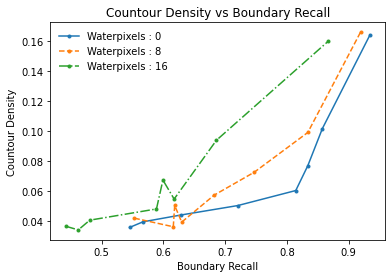

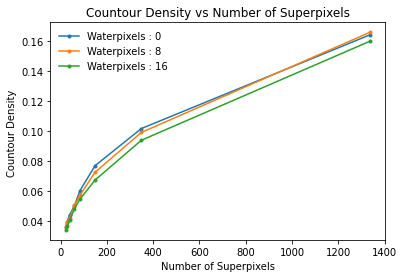

In [ ]:
plt.title("Countour Density vs Boundary Recall") 
plt.xlabel("Boundary Recall") 
plt.ylabel("Countour Density")

lineStyle = ['.-', '.--', '.-.']

for i in range(3):
  argSort = np.argsort(boundaries[i])
  x = np.array(boundaries[i])[argSort]
  y = np.array(contours[i])[argSort]
  plt.plot(x,y, lineStyle[i], label="Waterpixels : " + str(8*i)) 

plt.legend(loc='upper left', frameon=False)
plt.show()

plt.title("Countour Density vs Number of Superpixels") 
plt.xlabel("Number of Superpixels") 
plt.ylabel("Countour Density ") 

for i in range(3):
  argSort = np.argsort(pixels[i])
  x = np.array(pixels[i])[argSort]
  y = np.array(contours[i])[argSort]
  plt.plot(x,y, '.-', label="Waterpixels : " + str(8*i)) 

plt.legend(loc='upper left', frameon=False)
plt.show()

###2 - SLIC and LSC


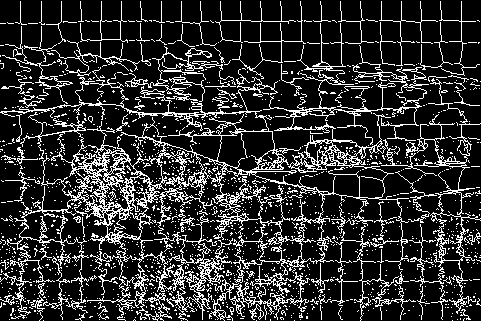

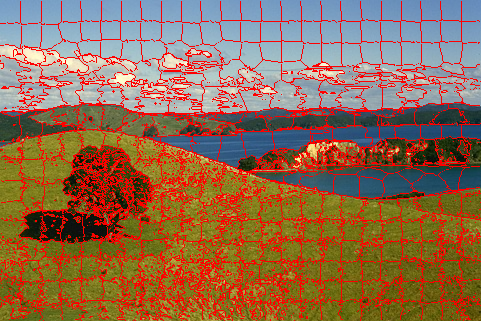

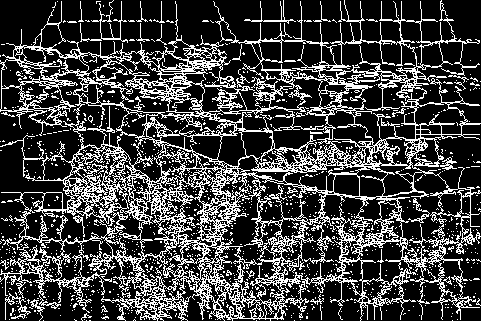

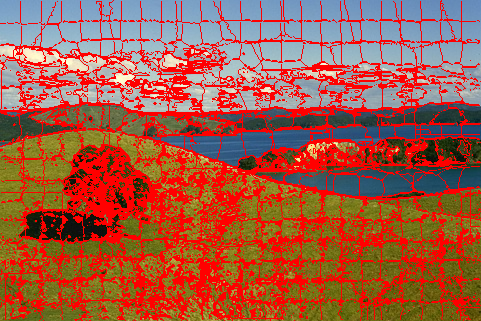

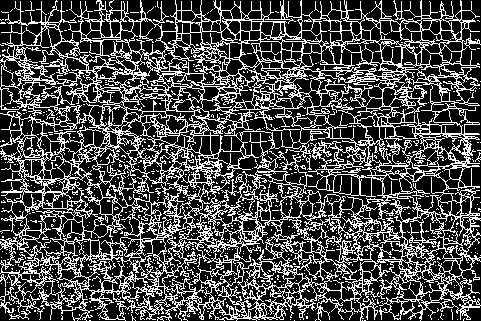

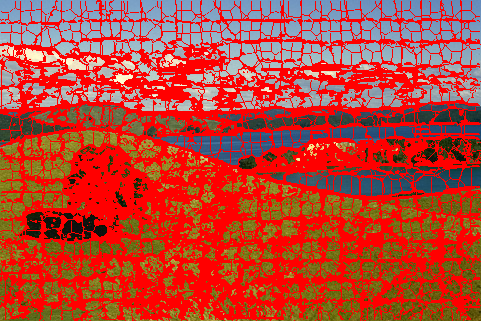

In [ ]:
from PIL import Image

def visualize(img, edges):
  cv2_imshow(edges)

  R, G, B = 255, 0, 0
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if(edges[i][j]):
        img[i][j][0] = B
        img[i][j][1] = G
        img[i][j][2] = R
          
  cv2_imshow(img)

imagePaths = ['/test/36046.jpg', '/test/228076.jpg', '/test/235098.jpg']
groundTruthPaths = ['/test/36046.mat', '/test/228076.mat', '/test/235098.mat']

i = 0
img = readImage(imagePaths[i],1)
'''
slic = cv2.ximgproc.createSuperpixelSLIC(img, 100, region_size = 25, ruler = 40.0)
slic.iterate(3)
borderSlic = slic.getLabelContourMask(img,True)
visualize(img, borderSlic)
hitEdgesVisualization(borderSlic, groundTruthPaths[i], visualize = True)
'''
lsc = cv2.ximgproc.createSuperpixelLSC(img, region_size = 20, ratio = 0.05)
lsc.iterate(3)
borderLsc = lsc.getLabelContourMask(img,True)
visualize(img, borderLsc)

lsc = cv2.ximgproc.createSuperpixelLSC(img, region_size = 40, ratio = 0.05)
lsc.iterate(3)
borderLsc = lsc.getLabelContourMask(img,True)
visualize(img, borderLsc)

lsc = cv2.ximgproc.createSuperpixelLSC(img, region_size = 10, ratio = 0.05)
lsc.iterate(3)
borderLsc = lsc.getLabelContourMask(img,True)
visualize(img, borderLsc)
